# NASS Statistics Data Acquisition

There is an API to access the data [here](https://quickstats.nass.usda.gov). The graphical user interface at that link can be used to explore what kinds of data are available through the API. The API can be install be installed by opening up a terminal and typing: `pip install nass`. 

In [8]:
import nass
import pandas as pd
import datetime
import numpy as np
import shutil
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from simpledbf import Dbf5
import seaborn as sns
from matplotlib.patches import Polygon
from matplotlib.colors import ListedColormap
from matplotlib.collections import PatchCollection
%matplotlib inline

# Credentials 

In [9]:
api = nass.NassApi('2B11C3F2-2AB8-3546-981D-C438F0A1AA2E')

# Functions

In [10]:
def get_crop_progress(state,year,week, stage, crop = 'CORN', series = False):
    '''
    state   A two-letter state abbreviation, eg: IL for Illinois
    
    year    YYYY, eg: 2017
    
    stage   Pick from the following for CORN:
            - PCT PLANTED
            - PCT EMERGED
            - PCT SILKING
            - PCT DENTED
            - PCT DOUGH
            - PCT MATURE
            - PCT HARVESTED
            
            Pick from the following for SOYBEANS:
            - PCT SEEDBED PREPARED
            - PCT PLANTED
            - PCT BLOOMING
            - PCT COLORING
            - PCT FULLY PODDED
            - PCT DROPPING LEAVES
            - PCT MATURE
            - PCT HARVESTED
        
    week   week number. Example: 47
    
    crop   CORN or SOYBEANS
    
    The output will be percentage completed of the selected stage at the year-week that is queried.

    '''
    
    q = api.query()
    q.filter('commodity_desc', crop).filter('year', year).\
    filter('state_alpha', state).filter('agg_level_desc', 'STATE').filter('source_desc', 'SURVEY').\
    filter('statisticcat_desc', 'PROGRESS').filter('unit_desc', stage)
    
    current_prog = q.execute()
    current_df = pd.DataFrame.from_records(current_prog)
    
    if series == False:
        # only select the percent progress on the most current record (current progress for this stage)
        return float(current_df['Value'][current_df['begin_code'] == str(week)].values[0])
    
    else:
        return current_df[['begin_code','Value']].sort_values(by=['begin_code']).reset_index()
    

def get_crop_progress_5yr_comp(state, year, week, stage, crop):
    '''
    state   A two-letter state abbreviation, eg: IL for Illinois
    
    year    YYYY, eg: 2017
    
    stage   Pick from the following for CORN:
            - PCT PLANTED
            - PCT EMERGED
            - PCT SILKING
            - PCT DENTED
            - PCT DOUGH
            - PCT MATURE
            - PCT HARVESTED
            
            Pick from the following for SOYBEANS:
            - PCT SEEDBED PREPARED
            - PCT PLANTED
            - PCT BLOOMING
            - PCT COLORING
            - PCT FULLY PODDED
            - PCT DROPPING LEAVES
            - PCT MATURE
            - PCT HARVESTED  
            
    week   week number. Example: 47
    
    crop   CORN or SOYBEANS
    
    The output will be percentage completed of the selected stage at the year-week that is queried,
    as well as the difference in weeks of this level of progress from the 5 year average.
    
    The difference in weeks (delta_wks) is POSITIVE if the query week is LATE
    The difference in weeks (delta_wks) is NEGATIVE if the query week is EARLY
    '''
    
    curpcprog = get_crop_progress(state,year,week, stage, crop = crop, series = False)
    
    prevyr = year - 1 # Note: use the previous year to get the 5 year normal so that we can look at 
                      # week numbers ahead of the current week number
    
    q = api.query()
    q.filter('commodity_desc', crop).filter('year', prevyr).\
    filter('state_alpha', state).filter('agg_level_desc', 'STATE').\
    filter('source_desc', 'SURVEY').filter('statisticcat_desc', 'PROGRESS, 5 YEAR AVG').\
    filter('unit_desc', stage)
    
    fiveyr_prog = q.execute()
    fiveyr_df = pd.DataFrame.from_records(fiveyr_prog)
    
    #  DIFFERENCE IN PERCENT AT STAGE PROGRESS FROM 5-YR NORM AT SAME WEEK
    # ====================================================================
    
    fiveyrpcprog = float(fiveyr_df['Value'][fiveyr_df['begin_code'] == str(week)])
    
    # the diff in progress in the queried week compared to prog in same week
    #  in 5 yr average
    
    diff_pc = curpcprog - fiveyrpcprog
    
     #  DIFFERENCE IN PROGRESS TIMING (WEEKS) from 5-YR NORMAL
    # ====================================================================
    
    fiveyr_wk = int(np.min(fiveyr_df.loc[pd.to_numeric(fiveyr_df['Value']) >= curpcprog, 'begin_code']))
    
    # SCALE the week (so we can get fractional values)
    fiveyr_wk1 = int(fiveyr_wk - 1)
    
    hipct = float(fiveyr_df.loc[fiveyr_df['begin_code'].astype(int) == int(fiveyr_wk), 'Value'])
    
    if hipct == 0:
        scfiveyr_wk = fiveyr_wk
    else:
        lowpct = float(fiveyr_df.loc[fiveyr_df['begin_code'].astype(int) == int(fiveyr_wk1), 'Value'])
        scfiveyr_wk = float(fiveyr_wk1) + float((curpcprog - lowpct)/ (hipct - lowpct))
        
    #the difference of the queried week to the 5 yr average to the same level of progress
    diff_wks = float(week) - scfiveyr_wk
    
    outdata = {
        'state': state,
        'year': year,
        'crop':crop,
        'stage':stage,
        'progress': curpcprog,
        'fiveyr_prog': fiveyrpcprog,
        'prog_diff_pc': diff_pc,
        'query_wk': week,
        'fiveyr_wk': scfiveyr_wk,
        'delta_wks':diff_wks
    }
    
    return outdata

In [11]:
get_crop_progress('IL', year = 2018, week = 20, stage = 'PCT EMERGED', crop = 'CORN')

84.0

In [12]:
get_crop_progress_5yr_comp(state = 'IL', year = 2017, week = 17, crop = 'CORN', stage = 'PCT EMERGED')

{'crop': 'CORN',
 'delta_wks': -0.533333333333335,
 'fiveyr_prog': 12.0,
 'fiveyr_wk': 17.533333333333335,
 'prog_diff_pc': 8.0,
 'progress': 20.0,
 'query_wk': 17,
 'stage': 'PCT EMERGED',
 'state': 'IL',
 'year': 2017}

In [13]:
get_crop_progress('IL', year = 2016, week = 25, stage = 'PCT SILKING', crop = 'CORN', series = True)

,index,begin_code,Value
0,0,24,0
1,1,25,4
2,2,26,22
3,3,27,53
4,4,28,77
5,5,29,90
6,6,30,97
7,7,31,100


In [14]:
get_crop_progress('IL', year = 2018, week = 30, stage = 'PCT BLOOMING', crop = 'SOYBEANS', series = True)

,index,begin_code,Value
0,0,24,3
1,1,25,23
2,2,26,44
3,3,27,64
4,4,28,79
5,5,29,88
6,6,30,92
7,7,31,95
8,8,32,100


# New Mapping Functions

Will need to download a shapefile (polygons) for US state boundaries

In [35]:
def plotmap(prog_dict, dev_dict, normmin = -2, normmax = 2, ticks=[-2,-1,0,1,2], 
            cmap = ListedColormap(sns.color_palette('Greens_r', 6) + sns.color_palette('YlOrRd', 7)), 
           label = 'Weeks ahead (neg) or behind (pos) 5 yr mean', outfn = ''):
    
    '''
    This function plots the choropleth map of the data obtained from NASS (differences from 5-yr mean)
    
    prog_dict is what will be printed as text in each state. This dictionary should contain 
    the percent progress in the given stage of that state.
    
    dev_dict is what will be printed in [] as text in each state, and the basis of the choropleth
    map colors
    
    The default values are those to be used when plotting 'delta weeks', or the number of weeks earlier
    or behind the 5-yr mean the current percent progress for given stage is. The default values are:
    
    normmin = -2
    normmax = 2
    ticks = [-2, -1, 0, 1, 2]
    cmap = ListedColormap(sns.color_palette('Greens_r', 6) + sns.color_palette('YlOrRd', 7))
    label = 'Weeks ahead (neg) or behind (pos) 5-year mean'
    
    Dictionaries where the values are the progress differences as a percentage ('prog_diff_pc') can also
    be plotted with the same command, simply by changing the input dictionary. In order for teh choropleth 
    to show up correctly, the other arguments should also be changed:
    
    normmin = -20
    normmax = 20
    ticks = [-20, -10, 0, 10, 20]
    cmap = ListedColormap(sns.color_palette('YlOrRd_r', 7) + sns.color_palette('Greens', 6)),
    label = 'Percent behind (neg) or ahead (pos) 5-year mean'
    
    '''
    
    # Set up the map
    colvals = dict1.values()
    cmap = cmap
    norm = plt.Normalize(normmin, normmax)
    
    fig = plt.figure(figsize=(8,8))
    map = Basemap(projection = 'lcc', resolution = 'l', \
                 lat_1 = 33, lat_2 = 45, lon_0 = -95,\
                 llcrnrlon = -105, llcrnrlat = 22, urcrnrlon = -64.5, urcrnrlat = 49)
    
    map.readshapefile('/home/theo/Data/cb_2017_us_state_20m_epsg4326/cb_2017_us_state_20m_epsg4326', \
                      name = 'states', drawbounds = True)
    
    # Assign colors to the states (from dict) to be plotted with choropleth (those that got data above)
    patches = []
    
    for info, shape in zip(map.states_info, map.states):
        if info['STUSPS'] in dev_dict.keys():
            color = cmap(norm(dev_dict[info['STUSPS']]))
            patches.append( Polygon(np.array(shape), True, color = color))
            
    ax = fig.add_subplot(111)
    pc = PatchCollection(patches, match_original = True, edgecolor = 'k', linewidth = 1., zorder=2)
    ax.add_collection(pc)
    sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
    sm.set_array(colvals)
    cb = map.colorbar(sm, location = 'bottom', size= '4%', pad = '1%', ticks = ticks)
    cb.set_label(label)
        
    # Add text - use the progress dict (prog_dict and dev_dict here)
    
    for state in dev_dict.keys():
        x,y = map(centroids[state]['coordinates'][0], centroids[state]['coordinates'][1])
        plt.text(x,y, str(dev_dict[state]) + '\n [' + str(prog_dict[state]) + '[', fontsize = 8, ha = 'center', va = 'center')
        
    if outfn == '':
        plt.show()
    else:
        plt.savefig(outfn)
        plt.show()

# Coordinates for Labels

In [17]:
# Create centroids and dictionary with all state centroids

import fiona
from shapely.geometry import shape, mapping

centroids = {}

with fiona.open('/home/theo/Data/cb_2017_us_state_20m/cb_2017_us_state_20m.shp') as input:
    for elem in input:
        # GeoJSON to shapely geometry
        geom = shape(elem['geometry'])
        # shapely centroid to GeoJSON
        centroids[elem['properties']['STUSPS']] = mapping(geom.centroid)


In [18]:
# fix coordinates for MI and LA
centroids['MI']['coordinates'] = ( -84.851, 43.255)
centroids['LA']['coordinates'] = (-92.536, 31.527)

# Maps for Corn Progress

In [19]:
# get current week of the year
datetime.date(2018,8,23).isocalendar()[1]

34

In [20]:
states = ['CO', 'IL', 'IN', 'IA', 'KS', 'KY', 'MI', 'MN',\
         'MO', 'NE', 'NC', 'ND', 'OH', 'PA', 'SD', 'TN', 'WI', \
         'TX', 'AL', 'MS', 'AR', 'LA', 'GA', 'SC', 'VA', 'OK', 'MD', 'WV']

year = 2018
week = 30
stage = 'PCT DOUGH'

nass_data = []
error_states = []

# COLLECT DICTIONARIES INTO LIST
for state in states:
    try:
        # make API call
        state_5yrcomp = get_crop_progress_5yr_comp(state, year, week, stage, crop = 'CORN')
        nass_data.append(state_5yrcomp)
    except:
        print ("NASS ERROR FOR %s"  %(str(state)))
        error_states.append(state)
        pass
    
# Convert to dataframe
nass_df = pd.DataFrame(nass_data)

print (error_states)

# remove error states from states
states = [x for x in states if x not in error_states]

NASS ERROR FOR AL
NASS ERROR FOR LA
NASS ERROR FOR GA
NASS ERROR FOR SC
NASS ERROR FOR MD
NASS ERROR FOR WV
['AL', 'LA', 'GA', 'SC', 'MD', 'WV']


In [21]:
# Make dictionary for states with chosen parameter: 'delta_wks' or 'prog_diff_pc'

dict1 = {}
keys = states

for state in states:
    prog_cur = nass_df['progress'][nass_df['state'] == state].values[0]
    if prog_cur > 0:
        try:
            dict1[state] = nass_df['delta_wks'][nass_df['state'] == state].values[0]
        except:
            dict1[state] = np.nan
    else:
        dict1[state] = np.nan

#remove states with NA
from math import isnan
dict1 = {k: dict1[k] for k in dict1 if not isnan(dict1[k])}
# round values
dict1 = {k: round(dict1[k],2) for k in dict1}

In [22]:
# Make the progress dict
progdict = {}

for state in states:
    prog_cur = nass_df['progress'][nass_df['state'] == state].values[0]
    if prog_cur > 0:
        try:
            progdict[state] = nass_df['progress'][nass_df['state'] == state].values[0]
        except:
            progdict[state] = np.nan
    else:
        progdict[state] = np.nan

#remove states with NA
from math import isnan
progdict = {k: progdict[k] for k in progdict if not isnan(progdict[k])}


/home/theo/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


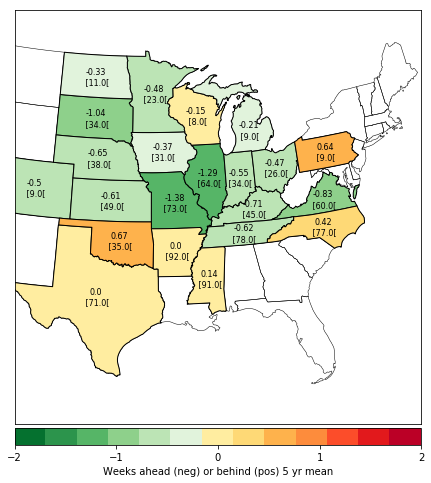

In [36]:
plotmap(progdict, dict1, normmin = -2, normmax = 2, ticks = [-2,-1,0,1,2],\
       outfn = '')